In [2]:
# Cell 1: Imports and notebook setup
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

In [3]:
# Cell 2: Helper to parse one YOLO‑pose line
def parse_yolo_pose(line):
    """
    Parse a YOLO‑pose annotation line:
      class_id x_center y_center width height [keypoints...]
    All coords are normalized.
    Returns (class_id, xc, yc, w, h)
    """
    parts = line.strip().split()
    cls_id = int(parts[0])
    xc, yc, w, h = map(float, parts[1:5])
    return cls_id, xc, yc, w, h

In [4]:
# Cell 3: Function to draw boxes & print sizes
def draw_and_report(image_path, ann_path, figsize=(12,8)):
    # Load image (BGR) and get dimensions
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Cannot read image: {image_path}")
    h_img, w_img = img_bgr.shape[:2]
    # Convert to RGB for Matplotlib
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Read annotation lines
    with open(ann_path, 'r') as f:
        lines = [l for l in f if l.strip()]

    # Prepare figure
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    ax = plt.gca()

    # Loop through instances
    for idx, line in enumerate(lines, start=1):
        cls_id, xc, yc, w_norm, h_norm = parse_yolo_pose(line)

        # Compute pixel dimensions
        box_w = w_norm * w_img
        box_h = h_norm * h_img

        # Compute pixel corners
        x_min = (xc - w_norm/2) * w_img
        y_min = (yc - h_norm/2) * h_img

        # Report
        print(f"[Instance {idx}] Class {cls_id}: width={box_w:.1f}px, height={box_h:.1f}px")

        # Draw rectangle
        rect = plt.Rectangle(
            (x_min, y_min), box_w, box_h,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)
        # Add label
        ax.text(
            x_min, y_min - 5,
            f"{cls_id}: {int(box_w)}×{int(box_h)}",
            color='lime', fontsize=10,
            bbox=dict(facecolor='black', alpha=0.5, pad=1, edgecolor='none')
        )

    plt.axis('off')
    plt.show()

[Instance 1] Class 0: width=68.5px, height=76.1px
[Instance 2] Class 0: width=77.5px, height=69.8px
[Instance 3] Class 0: width=96.2px, height=106.9px
[Instance 4] Class 0: width=100.8px, height=90.7px


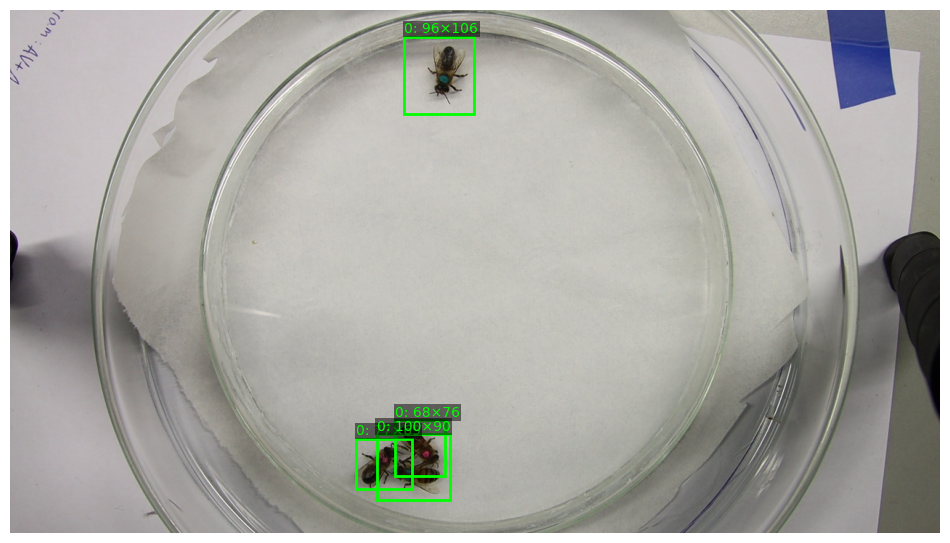

In [18]:
# Cell 4: Run on your files
image_path = "/Users/tristan/Downloads/BeeYOLOPose/YoloPoseBee/train/images/img02222.png"
ann_path   = "/Users/tristan/Downloads/BeeYOLOPose/YoloPoseBee/train/labels/img02222.txt"

draw_and_report(image_path, ann_path)

In [19]:
import os
import pandas as pd

def get_big_labels(root_dir, threshold=0.01):
    """
    Scans YOLO label files under <root_dir>/labels and prints full paths
    of those whose maximum normalized bounding-box area >= threshold.
    Returns a pandas DataFrame with columns ['label_file', 'max_area'] sorted by max_area descending.
    
    Args:
        root_dir (str): Directory containing 'labels' and (optionally) 'images' subfolders.
        threshold (float): Minimum normalized area (w*h) to consider "big".
    """
    lbl_dir = os.path.join(root_dir, 'labels')
    if not os.path.isdir(lbl_dir):
        raise ValueError(f"Labels directory not found: {lbl_dir}")
    
    big_files = []
    for fname in os.listdir(lbl_dir):
        if not fname.lower().endswith('.txt'):
            continue
        
        label_path = os.path.join(lbl_dir, fname)
        max_area = 0.0
        
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                w, h = float(parts[3]), float(parts[4])
                area = w * h
                if area > max_area:
                    max_area = area
        
        if max_area >= threshold:
            print(f"{label_path}  (max area = {max_area:.3f})")
            big_files.append((label_path, max_area))
    
    if not big_files:
        print("No label files exceed the threshold.")
    else:
        print(f"\nTotal files found: {len(big_files)} (threshold = {threshold})")
    
    df = pd.DataFrame(big_files, columns=['label_file', 'max_area'])
    return df.sort_values('max_area', ascending=False).reset_index(drop=True)

# Example usage:
root_dir = '/Users/tristan/Downloads/BeeYOLOPose/YoloPoseBee/train'
df_big = get_big_labels(root_dir, threshold=0.05)
df_big

/Users/tristan/Downloads/BeeYOLOPose/YoloPoseBee/train/labels/img15202.txt  (max area = 0.124)
/Users/tristan/Downloads/BeeYOLOPose/YoloPoseBee/train/labels/img12108.txt  (max area = 0.454)
/Users/tristan/Downloads/BeeYOLOPose/YoloPoseBee/train/labels/img00270.txt  (max area = 0.204)
/Users/tristan/Downloads/BeeYOLOPose/YoloPoseBee/train/labels/img08313.txt  (max area = 0.194)

Total files found: 4 (threshold = 0.05)


,label_file,max_area
0,/Users/tristan/Downloads/BeeYOLOPose/YoloPoseB...,0.453502
1,/Users/tristan/Downloads/BeeYOLOPose/YoloPoseB...,0.204324
2,/Users/tristan/Downloads/BeeYOLOPose/YoloPoseB...,0.193680
3,/Users/tristan/Downloads/BeeYOLOPose/YoloPoseB...,0.123579


In [ ]:
/Users/tristan/Downloads/BeeYOLOPose/YoloPoseBee/train/labels/img15202.txt  (max area = 0.124)
/Users/tristan/Downloads/BeeYOLOPose/YoloPoseBee/train/labels/img12108.txt  (max area = 0.454)
/Users/tristan/Downloads/BeeYOLOPose/YoloPoseBee/train/labels/img00270.txt  (max area = 0.204)
/Users/tristan/Downloads/BeeYOLOPose/YoloPoseBee/train/labels/img08313.txt  (max area = 0.194)

Total files found: 4 (threshold = 0.05)

Found 4 label files with max‐box area ≥ 0.05:
 • img15202.txt  (max area = 0.124)
 • img12108.txt  (max area = 0.454)
 • img00270.txt  (max area = 0.204)
 • img08313.txt  (max area = 0.194)


,label_file,max_area
0,img12108.txt,0.453502
1,img00270.txt,0.204324
2,img08313.txt,0.193680
3,img15202.txt,0.123579
